In [2]:
%load_ext autoreload
%autoreload 2

import cosmohmc.distnd.sampler as sampler
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def gaussian_log_prob(x, mean=0, variance=1):
    """Compute log probability of Gaussian with given mean and variance at x."""
    return -0.5 * np.log(2 * np.pi * variance) - (x - mean)**2 / (2 * variance)

def gaussian_grad_log_prob(x, mean=0, variance=1):
    return -(x - mean) / variance

# Example: Creating the sampler for a Gaussian distribution
smplr = sampler.mcmcsampler(log_prob=lambda x: gaussian_log_prob(x, mean=0, variance=1),
                      proposal_width=1, n_samples=1000)
hmcsmplr = sampler.HMCsampler(log_prob=lambda x: gaussian_log_prob(x, 0, 1),grad_log_prob=lambda x: gaussian_grad_log_prob(x),
                     step_size=0.1, n_steps=10, n_samples=1000)

mcmcsamples = smplr.sample()
hmcsamples = hmcsmplr.sample()


Sampling (HMC): 100%|██████████| 1000/1000 [00:00<00:00, 6785.51it/s]


In [4]:
smplr.acceptance_rate

0.689

In [5]:
hmcsmplr.acceptance_rate

0.999

In [26]:
def log_prob_gaussian(x, mean=np.zeros(2), covariance=np.eye(2)):
    inv_covariance = np.linalg.inv(covariance)
    n = len(mean)
    return -0.5 * np.dot(x - mean, np.dot(inv_covariance, x - mean))

# Gradient of the log probability for a 2D Gaussian distribution
def grad_log_prob_gaussian(x, mean=np.zeros(2), covariance=np.eye(2)):
    inv_covariance = np.linalg.inv(covariance)
    return -np.dot(inv_covariance, x - mean)

In [27]:
sampler_mcmc = sampler.mcmcsampler2D(log_prob=lambda x: log_prob_gaussian(x),
                             proposal_width=0.5, n_samples=10000)
samples_mcmc = sampler_mcmc.sample()

# Instantiate and use the HMCsampler2D
sampler_hmc = sampler.HMCsampler2D(log_prob=lambda x: log_prob_gaussian(x),
                           grad_log_prob=lambda x: grad_log_prob_gaussian(x),
                           step_size=0.1, n_steps=20, n_samples=10000)
samples_hmc = sampler_hmc.sample()

In [28]:
print("MCMC Sampler Acceptance Rate:", sampler_mcmc.acceptance_rate)
print("HMC Sampler Acceptance Rate:", sampler_hmc.acceptance_rate)

MCMC Sampler Acceptance Rate: 0.7484
HMC Sampler Acceptance Rate: 0.9994


In [30]:
samples_mcmc = np.array(samples_mcmc)
samples_hmc = np.array(samples_hmc)

In [37]:
def gaussian_log_prob(x, mean=np.zeros(4), covariance=np.identity(4)):
    """Compute the log probability of a multivariate Gaussian."""
    dim = mean.shape[0]
    return -0.5 * (np.dot((x - mean).T, np.linalg.inv(covariance)).dot(x - mean) + dim * np.log(2 * np.pi) + np.log(np.linalg.det(covariance)))

def gaussian_grad_log_prob(x, mean=np.zeros(4), covariance=np.identity(4)):
    """Compute the gradient of the log probability for a multivariate Gaussian."""
    return -np.dot(np.linalg.inv(covariance), (x - mean))

In [1]:
mcmc_sampler = sampler.mcmcsamplerN(log_prob=lambda x: gaussian_log_prob(x),
                            dim=4, proposal_width=1, n_samples=10000)

mcmc_samples = mcmc_sampler.sample()

hmc_sampler = sampler.HMCsamplerN(log_prob=lambda x: gaussian_log_prob(x),
                          grad_log_prob=lambda x: gaussian_grad_log_prob(x),
                          dim=4, step_size=0.1, n_steps=10, n_samples=10000)

hmc_samples = hmc_sampler.sample()

NameError: name 'sampler' is not defined

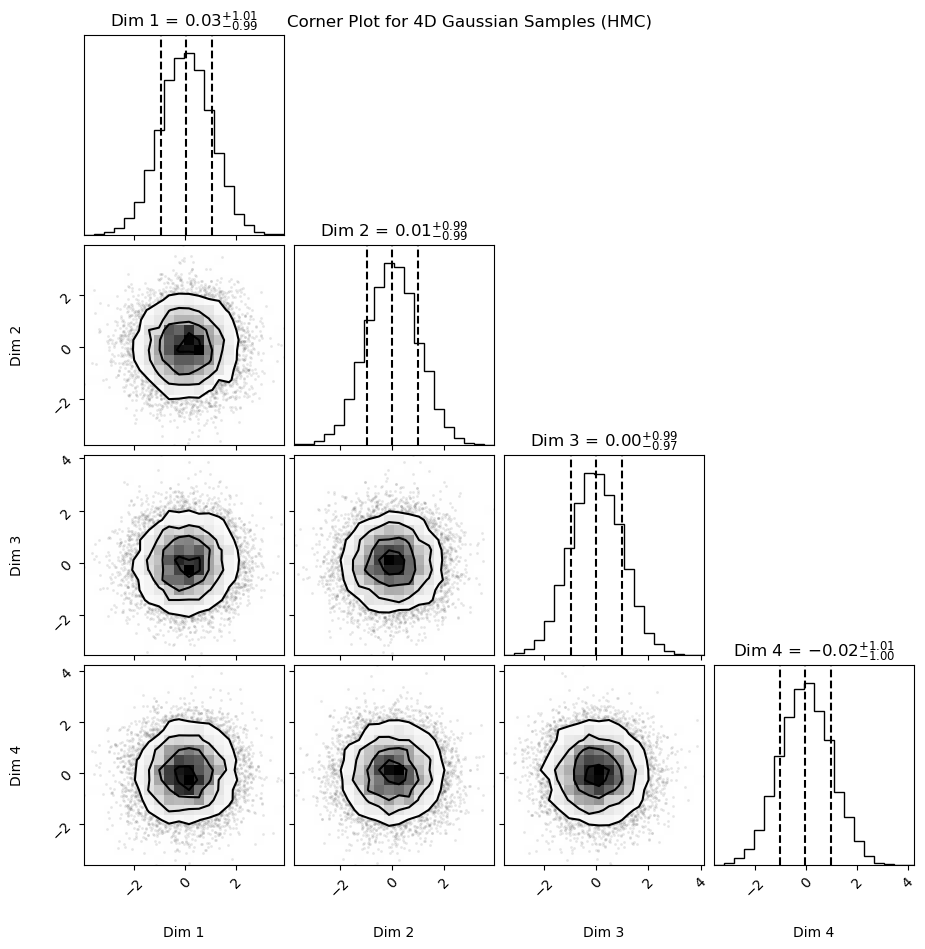

In [40]:
import corner
import numpy as np

# Assuming `hmc_samples` is a list of numpy arrays, where each numpy array represents a sample in 4D space
hmc_samples_np = np.array(hmc_samples)  # Convert the list of samples to a NumPy array for compatibility with corner

figure = corner.corner(hmc_samples_np, labels=["Dim 1", "Dim 2", "Dim 3", "Dim 4"],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

figure.suptitle('Corner Plot for 4D Gaussian Samples (HMC)')
plt.show()

In [35]:
print(f"MCMC Sampler Acceptance Rate: {mcmc_sampler.acceptance_rate:.4f}")
print(f"HMC Sampler Acceptance Rate: {hmc_sampler.acceptance_rate:.4f}")


MCMC Sampler Acceptance Rate: 0.6405
HMC Sampler Acceptance Rate: 0.9989


In [41]:
def mixture_of_gaussians_log_prob(x):
    mean1 = np.array([2.0, 2.0])
    cov1 = np.array([[1.0, 0.2], [0.2, 1.0]])
    mean2 = np.array([-2.0, -2.0])
    cov2 = np.array([[1.0, -0.2], [-0.2, 1.0]])
    
    log_prob1 = -0.5 * (np.dot((x - mean1).T, np.linalg.inv(cov1)).dot(x - mean1) + np.log(np.linalg.det(cov1)) + 2 * np.log(2 * np.pi))
    log_prob2 = -0.5 * (np.dot((x - mean2).T, np.linalg.inv(cov2)).dot(x - mean2) + np.log(np.linalg.det(cov2)) + 2 * np.log(2 * np.pi))
    
    return np.log(np.exp(log_prob1) + np.exp(log_prob2)) - np.log(2)  # Assuming equal mixture weights

def numerical_grad(f, x, h=1e-5):
    """A general purpose function to compute numerical gradient of f at x."""
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_h_plus = np.array(x)
        x_h_minus = np.array(x)
        x_h_plus[i] += h
        x_h_minus[i] -= h
        grad[i] = (f(x_h_plus) - f(x_h_minus)) / (2 * h)
    return grad

In [42]:
dim = 2  # Dimensionality of the distribution

hmc_sampler_mog = sampler.HMCsamplerN(
    log_prob=lambda x: mixture_of_gaussians_log_prob(x),
    grad_log_prob=lambda x: numerical_grad(mixture_of_gaussians_log_prob, x),
    dim=dim, step_size=0.1, n_steps=50, n_samples=10000
)

mc_sampler_mog = sampler.mcmcsamplerN(
    log_prob=lambda x: mixture_of_gaussians_log_prob(x),
    dim=dim, proposal_width=0.5, n_samples=10000
)

mc_samples_mog = mc_sampler_mog.sample()
hmc_samples_mog = hmc_sampler_mog.sample()

Sampling (HMC): 100%|██████████| 10000/10000 [01:58<00:00, 84.40it/s]


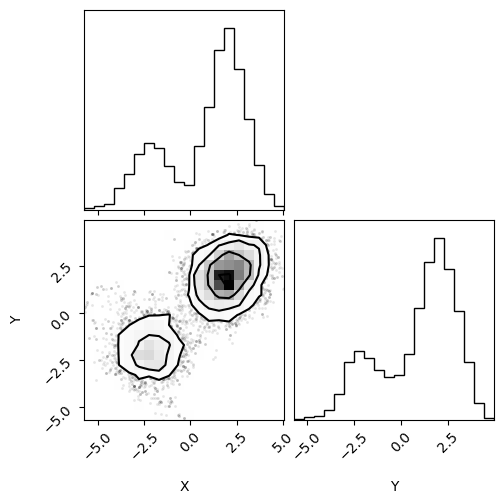

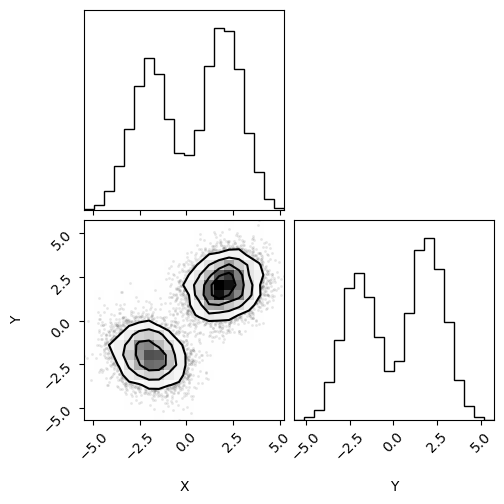

In [47]:
# Creating corner plots
fig_mcmc = corner.corner(mc_samples_mog, labels=["X", "Y"], 
                         title="MCMC Samples", hist_kwargs={"density": True})

fig_hmc = corner.corner(hmc_samples_mog, labels=["X", "Y"], 
                        title="HMC Samples", hist_kwargs={"density": True})

In [48]:
print(f"MCMC Sampler Acceptance Rate: {mc_sampler_mog.acceptance_rate:.4f}")
print(f"HMC Sampler Acceptance Rate: {hmc_sampler_mog.acceptance_rate:.4f}")


MCMC Sampler Acceptance Rate: 0.7530
HMC Sampler Acceptance Rate: 0.9987
